# Logistic Regression Implementation

## Load libraries

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist

## Loading MNIST Dataset

In [111]:

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Converting the dataset to binary (keeping only 0 and 1 instances)

In [112]:
X_tran_binary = X_train[Y_train <= 1]
Y_tran_binary = Y_train[Y_train <= 1]

X_test_binary = X_test[Y_test <= 1]
Y_test_binary = Y_test[Y_test <= 1]

In [113]:
X_tran_binary.shape

(12665, 28, 28)

In [114]:
Y_tran_binary.shape

(12665,)

## Flatten the dataset

In [115]:
X_train_flat = X_tran_binary.reshape(X_tran_binary.shape[0], X_tran_binary.shape[1]*X_tran_binary.shape[2]).T

X_test_flat = X_test_binary.reshape(X_test_binary.shape[0], X_test_binary.shape[1]*X_test_binary.shape[2]).T

In [116]:
X_train_flat.shape

(784, 12665)

## Standarization

In [117]:
X_train_flat = X_train_flat/255
X_test_flat = X_test_flat/255

## Mathematical expression of the algorithm

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## Sigmoid function
$\sigma( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [118]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    return  1/(1+np.exp(-z))

## Initializing weights and biases

In [119]:

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0
    
    ## Some unit testing
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$


$$ \frac{\partial L}{\partial a} = - \frac{y}{a} + \frac{1-y}{1-a}$$
$$ \frac{\partial L}{\partial z} = (a-y)$$
$$ \frac{\partial z}{\partial b} = 1$$
$$ \frac{\partial z}{\partial w} = X$$
$$ \frac{\partial L}{\partial b} = \frac{\partial L}{\partial z} \frac{\partial z}{\partial b} = (a-y) $$
$$ \frac{\partial L}{\partial w} = \frac{\partial L}{\partial z} \frac{\partial z}{\partial w} = X(a-y) $$

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [120]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    # Num of instanses
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                # compute activation
    cost = -1/m*(np.sum(np.dot(Y,np.log(A).T)) + np.dot(1-Y,np.log(1-A).T)) # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = 1/m * np.dot(X,(A-Y).T) 
    db = 1/m * np.sum(A-Y)  

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

## Gradient Descent
The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [121]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * (dw)
        b = b - learning_rate * (db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [122]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction = (A > 0.5).astype(int)
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [123]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [124]:
d = model(X_train_flat, Y_tran_binary, X_test_flat, Y_test_binary, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.201280
Cost after iteration 200: 0.120349
Cost after iteration 300: 0.088112
Cost after iteration 400: 0.070691
Cost after iteration 500: 0.059708
Cost after iteration 600: 0.052112
Cost after iteration 700: 0.046521
Cost after iteration 800: 0.042221
Cost after iteration 900: 0.038801
Cost after iteration 1000: 0.036010
Cost after iteration 1100: 0.033685
Cost after iteration 1200: 0.031714
Cost after iteration 1300: 0.030021
Cost after iteration 1400: 0.028548
Cost after iteration 1500: 0.027255
Cost after iteration 1600: 0.026108
Cost after iteration 1700: 0.025083
Cost after iteration 1800: 0.024162
Cost after iteration 1900: 0.023329
train accuracy: 99.73943939992104 %
test accuracy: 99.90543735224587 %


In [157]:
a = pd.DataFrame(Y_test_binary)
a[1] = d['Y_prediction_test'].T

In [159]:
a[2] = a[1] - a[0]

In [163]:
a[2][a[2] != 0]

1388    1
2031    1
Name: 2, dtype: int64

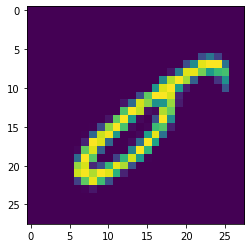

In [164]:
plt.imshow(X_test_binary[1388])

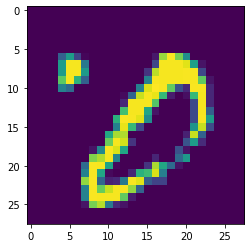

In [165]:
plt.imshow(X_test_binary[2031])
